In [1]:
import numpy as np
import tangos as db
import pickle as pck
import pynbody
import matplotlib.pyplot as plt
import scipy.integrate as integ
import math as ma
plt.ion()

plt.rcParams['figure.figsize'] = (12, 9) 
plt.rcParams['font.size'] = 20  
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['xtick.major.size'] = 10 
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1

sim = db.get_simulation('h1.cosmo50')

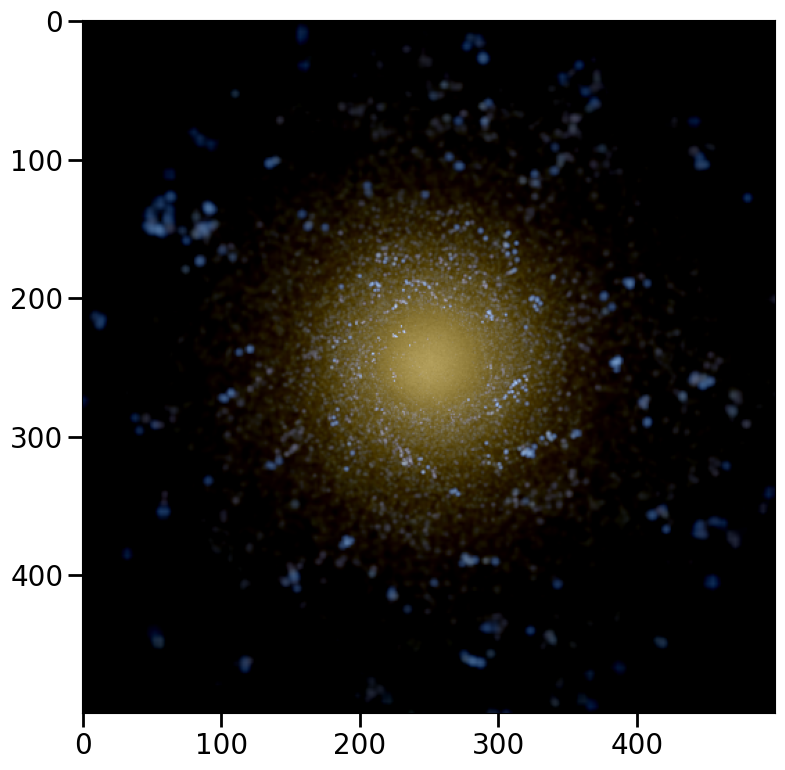

In [3]:
sim.timesteps
halo = db.get_halo('h1.cosmo50/%4032/4')
plt.imshow(halo['stellar_image_faceon'])

In [2]:
def host_density(halo_num,bh_index,R_min=0.7,R_max=1.75,plot:bool=False):
    
    halo= db.get_halo('h1.cosmo50/%4096/'+str(halo_num))
    bh = halo['BH_central'][bh_index]
    mass = bh['BH_mass']
    bhid = bh.halo_number
    dist = bh['BH_central_distance']
        
    #shrink_h1,time_h1,max_radius = halo.calculate_for_progenitors('shrink_center','t()','max_radius')
    hostid,host_path,time,center_dist = bh.calculate_for_progenitors('host_halo.halo_number()','host_halo.path()','t()','BH_central_distance')
    
    if all(i>1 for i in center_dist):
        print('ERROR: This BH was never central')
        return 0,0,0,0,0,0,0,0,0,0
    
    if all(i==halo_num for i in hostid):
        print('ERROR: This BH never left the input halo')
        return 0,0,0,0,0,0,0,0,0,0
    
    index = np.where(hostid!=halo_num)[0][0]

    if center_dist[index]>1:
        
        for i in range(len(hostid)):
            
            if (hostid[i]!=halo_num) & (center_dist[i]<1):
                index = i
                break
            else:
                pass
    
    original_halo = db.get_halo(host_path[index])
    
    shrink = original_halo['shrink_center']
    #print(shrink)
    dist1 = np.sqrt(((shrink[0])**2)+((shrink[1])**2)+((shrink[2])**2))
    #print(dist)

    z = host_path[index].split('.')[-1][0:6]
    #print(z)
    halo2 = db.get_halo('h1.cosmo50/%'+str(z)+'/1')
    shrink2 = halo2['shrink_center']
    #print(shrink2)
    dist2 = np.sqrt(((shrink2[0])**2)+((shrink2[1])**2)+((shrink2[2])**2))
    #print(dist2)
    radius = halo2['max_radius']
    difference = np.abs(dist2-dist1)
    #print(difference)
    #print(host_path[index])
    if difference < radius:
    
        #print('First original inside h1')
    
        inside=-1
        outside:bool = False
    
        while outside==False:
        
            #print(outside)
            index+=1
            if index >= len(hostid):
                print('ERROR the BH never met the three conditions')
                return 0,0,0,0,0,0,0,0,0,0

            if (hostid[index]!=halo_num) & (center_dist[index]<1):
                
                original_halo = db.get_halo(host_path[index])
            
                #print(original_halo)
            
                shrink = original_halo['shrink_center']
            
                #print(shrink)
            
                dist1 = np.sqrt(((shrink[0])**2)+((shrink[1])**2)+((shrink[2])**2))
            
                #print('original halo:',dist)
            
                z = host_path[index].split('.')[-1][0:6]
                halo2 = db.get_halo('h1.cosmo50/%'+str(z)+'/1')
                shrink2=halo2['shrink_center']
                dist2= np.sqrt(((shrink2[0])**2)+((shrink2[1])**2)+((shrink2[2])**2))
                #print(shrink2)
                #print('halo1:',dist2)
            
                diff = abs(dist2-dist1)
                radius = halo2['max_radius']
                #print('rad:',radius)
                #print('diff:',diff)
            
                if diff>=radius:
                    #print('yes')
                    outside = True
                
                                   
    else:   
        inside = 0

    stepp = original_halo.timestep
    step = time[index]
    full_mass = original_halo['Mstar']
    
    if step < 0.65:
        print('ERROR: no original host')
        return 0,0,0,0,0,0,0,0,0,0
              
    if full_mass>10000000:
        res=0
    else:
        res=-1
        print('ERROR: host galaxy not resolved')
        return 0,0,0,0,0,0,0,0,0,0
    
    if 'star_density_profile' in original_halo:
        print('Original BH Host:',original_halo.halo_number)
        print('BH id:',bhid)
        print('Time in simulation:',step,'Gyr') 
    else:
        print('ERROR: The original host has no density profile')
        return  0,0,0,0,0,0,0,0,0,0
    
    rbins = np.arange(len(original_halo['star_density_profile']))*0.1+0.5
    density = original_halo['star_density_profile']
    ok = np.where(density>0) 
    start_cut_off = (R_min*10)-5
    end_cut_off=(R_max*10)-4
    rounded = round(R_max,1)
    
    if rounded!=R_max:
        end_cut_off+=1   
        
    if len(density[ok])==0:
        print('ERROR: Star density within '+str(R_min)+'kpc is zero')
        return 0,0,0,0,0,0,0,0,0,0
    
    if 'star_mass_profile' in original_halo:
        original_mass = original_halo.calculate('at('+str(R_min)+',star_mass_profile)')
        if original_mass ==0:
            original_mass=1
    else:
        original_mass = 1  
    
    check = np.array_equal(density,density[ok])
    zero=0   
    
    if check==False:
        #print('ERROR: Zero density values detected - erased from plot')
        zero=-1
       
    plotbins = rbins[ok][0:int(end_cut_off)]
    plot_density = density[ok][0:int(end_cut_off)]

    steps = rbins[ok][int(start_cut_off):int(end_cut_off)]
    
    if len(steps) == 0:
        print('ERROR: Not enough density points to evaluate')
        return 0,0,0,0,0,0,0,0,0,0
    
    y = np.log(plot_density[int(start_cut_off):int(end_cut_off)])
    x = np.log(steps)

    constants = np.polyfit(x,y,1)
    a = np.exp(constants[1])
    b = -constants[0]
   
    #print('Parameters:',a,b) 

    steps2 = np.arange(0,R_min,0.1)
    new_steps = np.append(steps2,steps)

    plotbins2 = np.arange(0,0.5,0.1)
    new_plotbins = np.append(plotbins2,plotbins)

    def function(x):
        y = []
        y = a*x**(-b)
        return y

    y = function(new_plotbins)

    if plot==True:
        plt.plot(plotbins,plot_density,ls='-',c='deeppink',lw=4,label='Simulation Data')
        plt.yscale('log')
        plt.ylabel(r'Stellar Density [M$_{\odot}$/kpc$^3$]')
        plt.xlabel(r'R [kpc]')
        #plt.title('Stellar Density of Host at 0-'+str(R_max)+'kpc')
        plt.axvline(x=center_dist[index], label='BH Location',c='darkblue',lw=2,ls='--')
        plt.axvline(x=0.7,label='Resolution Limit',c='deepskyblue',lw=2,ls='--')
        plt.legend(loc='upper right')
        
        plt.plot(new_plotbins,y,c='pink',ls='-.',label='Extrapolated Star Desnity',lw=3)
        plt.yscale('log')
        plt.legend(loc='upper right')
    
    return a,b,bhid,stepp,original_halo,mass,step,full_mass,dist,bh_index



Original BH Host: 10
BH id: 568954394
Time in simulation: 1.627593993470575 Gyr


/tmp/ipykernel_1116040/3925882411.py:176: RuntimeWarning: divide by zero encountered in power
  y = a*x**(-b)


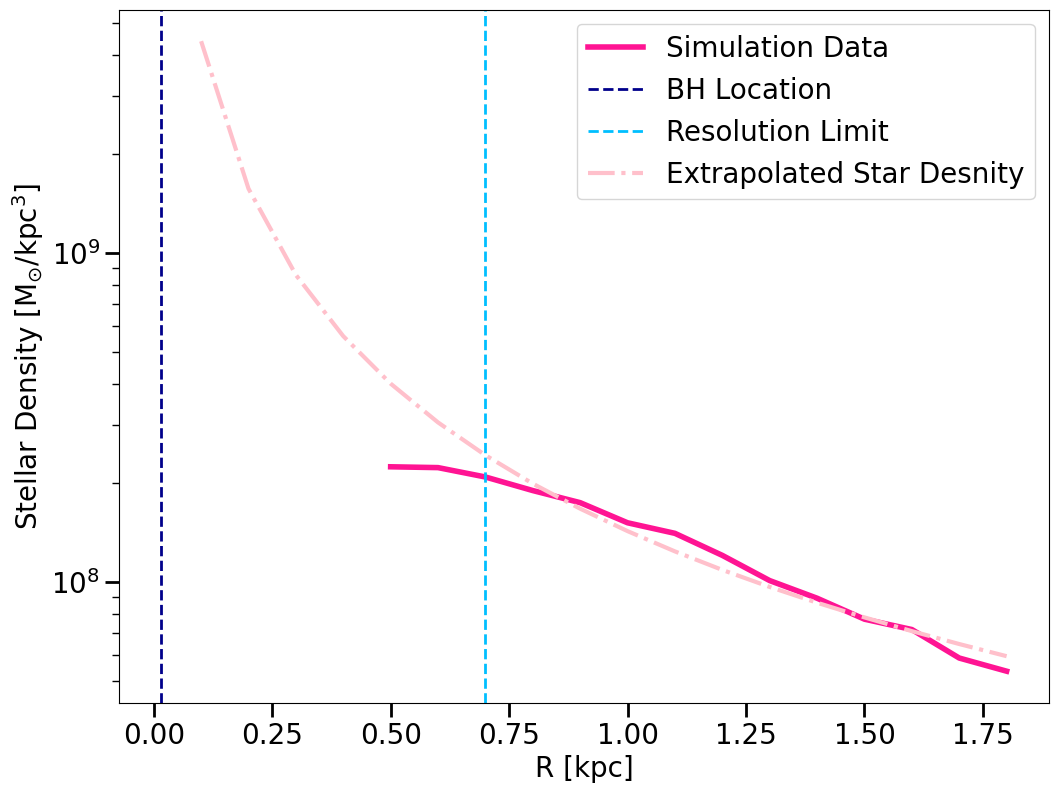

In [4]:
host_density(1,3,plot=True)
plt.savefig('extrapolation.png')

In [5]:
def normalise_full(bh_index,halo_num=1,radius=0.35):
    a,b,bhid,step,original_halo,m,n,v,c,x =  host_density(halo_num,bh_index)
    def function(x):
        y = []
        y = a*x**(-b)
        return y
    density = function(radius)
    C = density*(radius**2)
    return C,original_halo,step

In [13]:
def normalise(a,b,radius=0.35):
    def function(x):
        y = []
        y = a*x**(-b)
        return y
    density = function(radius)
    C = density*(radius**2)
    return C

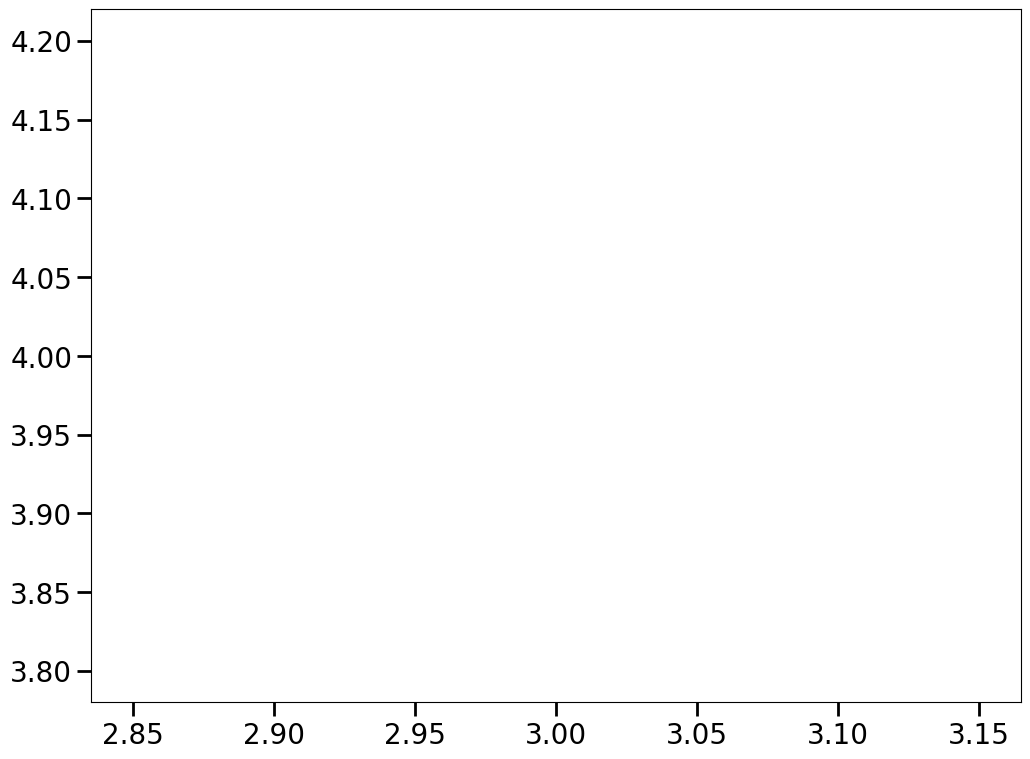

In [23]:
plt.plot(time,(1200-dist*10))
plt.plot(3,4)

Original BH Host: 60
BH id: 570127988
Time in simulation: 1.627593993470575 Gyr


/tmp/ipykernel_1050754/3894522514.py:176: RuntimeWarning: divide by zero encountered in power
  y = a*x**(-b)


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True]
[60 34 40 32 35  1 86 84 88  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
[ 1.62759399  1.95077639  2.15276538  2.27395878  2.59714118  2.92032357
  3.24350596  3.29063673  3.56668836  3.88987075  4.21305314  4.53623554
  4.85941793  5.18260033  5.50578272  5.82896511  5.86936291  6.15214751
  6.7985123   6.93317163  7.03753261  7.12169469  7.29675182  7.44487708
  7.67043146  7.76805948  8.06094352  8.09124187  8.41442427  8.468288
  8.6096803   8.73760666  8.88573192  9.06078905  9.32000827  9.3839

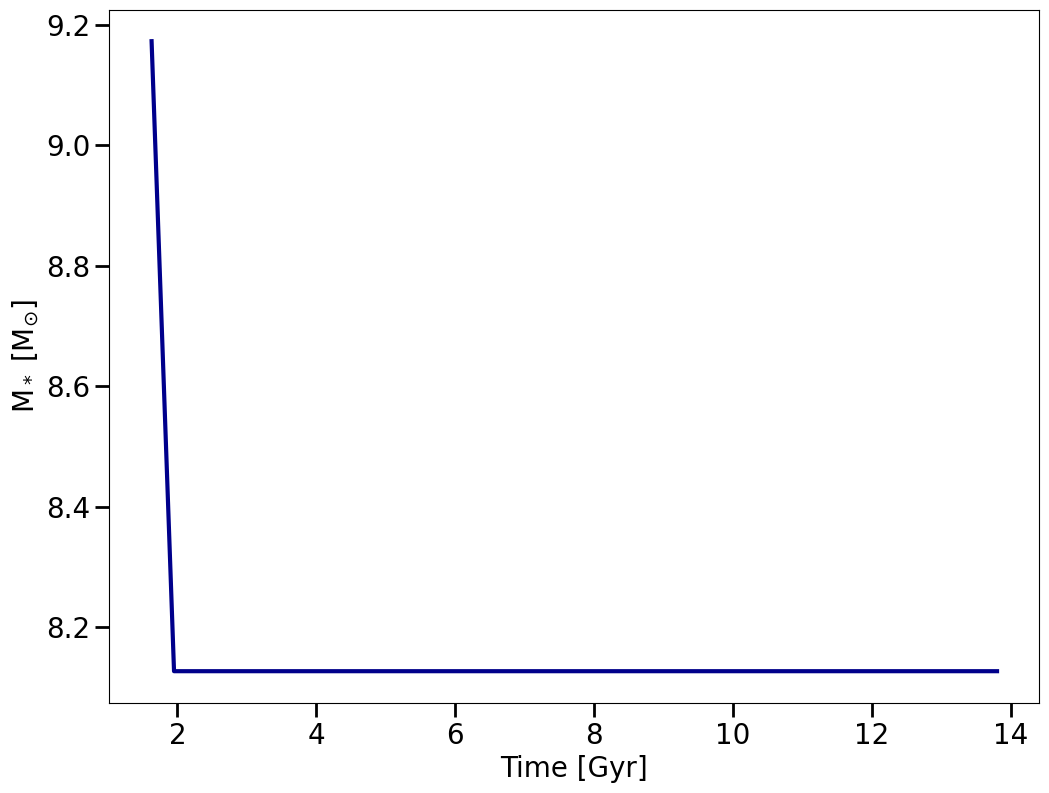

In [24]:
rj,time,m,bhm,dist = tidal_history_full(570127988,156)
plt.plot(time,np.log10(m),c='darkblue',lw=3)
plt.ylabel('M$_*$ [M$_{\odot}$]')
plt.xlabel('Time [Gyr]')
plt.savefig('one.png')


In [12]:
def tidal_history_full(bhid,BH_index,halo_num=1):
    
    C,original_halo,step= normalise_full(BH_index)
    short_step = int(step.path.split('.')[-1])
    original_halo_num = int(original_halo.path.split('_')[-1])
    short_step = str(short_step)
    if len(short_step)!=4:
        short_step = str(0)+str(short_step)
        if len(short_step)!=3:
            short_step = str(0)+str(short_step)
        
    halo= db.get_halo('h1.cosmo50/%'+str(short_step)+'/'+str(halo_num))
    host= db.get_halo('h1.cosmo50/%'+str(short_step)+'/'+str(original_halo_num))
    bh = db.get_halo('h1.cosmo50/%'+str(short_step)+'/BH_'+str(bhid))

    mass_hist,radius_hist,tim = halo.calculate_for_descendants('at(radius(200),star_mass_profile)','max_radius','t()')
    host_num_hist,dist,time,bh_mass= bh.calculate_for_descendants('host_halo.halo_number()','BH_central_distance','t()','BH_mass')
    #host_mass = host.calculate('at(1.4,star_mass_profile)')
    
    y = np.in1d(tim,time)
    print(y)
    #print(host,bh)
    print(host_num_hist)
    
    # for i in range(len(mass_hist)):
    #     if ((host_num_hist[i] == 1) & (host_num_hist[i+1] == 1)):
    #         index = i
    #         break
    # index2 = np.where(host_num_hist[i]==halo_num & host_num_hist==halo_num)
    # index3 = np.where(index2==index2)
    # print(index)
    # print(index2)
    # print(index3)
    #print(index)
    #print(host_radius_hist)
    
    # print(len(dist))
    # print(dist)
    # print(len(mass_hist))
    # print(mass_hist)
    print(tim)
    print(time)
    
    indexx = np.where(host_num_hist==halo_num)[0][0]
    host_num_hist = host_num_hist[indexx:]
    print(indexx)
    
    for i in range(len(host_num_hist)):
        print(host_num_hist)
        if all(i==halo_num for i in host_num_hist):
            print('Correct ')
            index = indexx
            break
        else:
            indexx = np.where(host_num_hist!=halo_num)[0][0]
            host_num_hist = host_num_hist[indexx+1:]
            
        
   
    
    if host_num_hist[-2] != host_num_hist[-3]:
        
        idd = bh.halo_number
        print('Error : the BH entered halo 1 too late in the simulation')
        
        return 0,idd,BH_index,0
    
    dist = dist[index:]
    mass_hist = mass_hist[index:]
    radius_hist = radius_hist[index:]
    time = time[index:]
    #host_radius_hist = host_radius_hist[0][index:]
    host_num_hist = host_num_hist[index:]
    bh_mass = bh_mass[index:]
    #print(host_num_hist,time)
    
    # print(len(dist))
    # print(dist)
    # print(len(mass_hist))
    # print(mass_hist)
    # print(tim)
    # print(time)
    
    # if all(i==halo_num for i in host_num_hist):
    #     print('Correct ')
    # else: 
    #     print('Error')
    #     return 0,0,0
    #print(host_radius_hist)
    
    rj=[]
    m=[]
    
    for i in range(len(dist)):
        if i == 0:
            
            M = mass_hist[i]
            R = dist[i]
            rj.append(1.4)
            m.append(C*4*np.pi*rj[i])            
            
        else: 
            #print('min:',min(rj))
            #print('new',rj[i])
            if rj[i]<=(min(rj)):
                #print('yes',i)
                m.append(C*4*np.pi*rj[i])
                
            else:
                
                m.append(m[i-1])
                
        M = mass_hist[i]
        R = dist[i]    
        rj.append((((m[i]/M)/(3+m[i]/M))**(1/3))*R)
        
    print(rj,time,m,bh_mass)
    return(rj,time,m,bh_mass,dist)

In [11]:
def tidal_history(a,b,bhid,BH_index,step,original_halo,halo_num=1):
    
    C = normalise(a,b)
    short_step = int(step.split('.')[-1])
    original_halo_num = int(original_halo.split('_')[-1])
    short_step = str(short_step)
    if len(short_step)!=4:
        short_step = str(0)+str(short_step)
        if len(short_step)!=3:
            short_step = str(0)+str(short_step)
        
    halo= db.get_halo('h1.cosmo50/%'+str(short_step)+'/'+str(halo_num))
    host= db.get_halo('h1.cosmo50/%'+str(short_step)+'/'+str(original_halo_num))
    bh = db.get_halo('h1.cosmo50/%'+str(short_step)+'/BH_'+str(bhid))

    mass_hist,radius_hist = halo.calculate_for_descendants('at(radius(200),star_mass_profile)','max_radius')
    host_num_hist,dist,time,bh_mass= bh.calculate_for_descendants('host_halo.halo_number()','BH_central_distance','t()','BH_mass')
    #host_mass = host.calculate('at(1.4,star_mass_profile)')

    indexx = np.where(host_num_hist==halo_num)[0][0]
    host_num_hist = host_num_hist[indexx:]
    
    for i in range(len(host_num_hist)):
        if all(i==halo_num for i in host_num_hist):
            index = indexx
            break
        else:
            indexx = np.where(host_num_hist!=halo_num)[0][0]
            host_num_hist = host_num_hist[indexx+1:]
            
    
    dist = dist[index:]
    mass_hist = mass_hist[index:]
    radius_hist = radius_hist[index:]
    time = time[index:]
    host_num_hist = host_num_hist[index:]
    bh_mass = bh_mass[index:]
    infall = time[0]
    
    # if all(i==halo_num for i in host_num_hist):
    #     print('Correct ')
    # else: 
    #     print('Error')
    #     return 0,0,0
    
    rj=[]
    m=[]
        
    for i in range(len(dist)):
        if i == 0:
            
            M = mass_hist[i]
            R = dist[i]
            rj.append(1.4)
            m.append(C*4*np.pi*rj[i])            
            
        else: 
           
            if rj[i]<=(min(rj)):
                m.append(C*4*np.pi*rj[i])
                
            else:
                
                m.append(m[i-1])
                
        M = mass_hist[i]
        R = dist[i]    
        rj.append((((m[i]/M)/(3+m[i]/M))**(1/3))*R)
        
       
    return(rj,time,m,bh_mass,infall)

In [9]:
import matplotlib.lines as mlines

f = open('Disruption_Outputs.pkl','rb')
data = pck.load(f)
f.close()

time = data['time']
mass = data['mass']
bh_mass=data['bh_mass']
print(time)
plt.plot(time[0][8],mass[0][8],c='darkblue',lw='3')
#plt.plot(time,bh_mass,ls=':',c='darkblue',lw='3')
#plt.plot(time1,m1,c='orange',lw='3')
#plt.plot(time1,mass1,ls=':',c='orange',lw='3')
#plt.plot(time2,m2,c='mediumvioletred',lw='3')
#plt.plot(time2,mass2,ls=':',c='mediumvioletred',lw='3')
#plt.plot(time5,m5,c='magenta',lw='3')
#plt.plot(time5,mass5,ls=':',c='magenta',lw='3')
plt.ylabel('M$_*$ [M$_{\odot}$]')
plt.xlabel('Time [Gyr]')
# Legend_elements = [mlines.Line2D([0], [0], color='k', ls='-',lw=2, label='Galaxy Mass'),
#                    mlines.Line2D([0], [0], color='k', ls='--', lw=2, label='BH_mass')]

#plt.legend(handles=Legend_elements,loc='lower right',bbox_to_anchor=(1, 0.23))
plt.legend(loc='upper right')
plt.yscale('log')
#plt.title('Mass evolution from Infall to 13.8 Gyrs')
#plt.xscale('log')
plt.savefig('Mass Evolution.png')

[]


IndexError: list index out of range

45


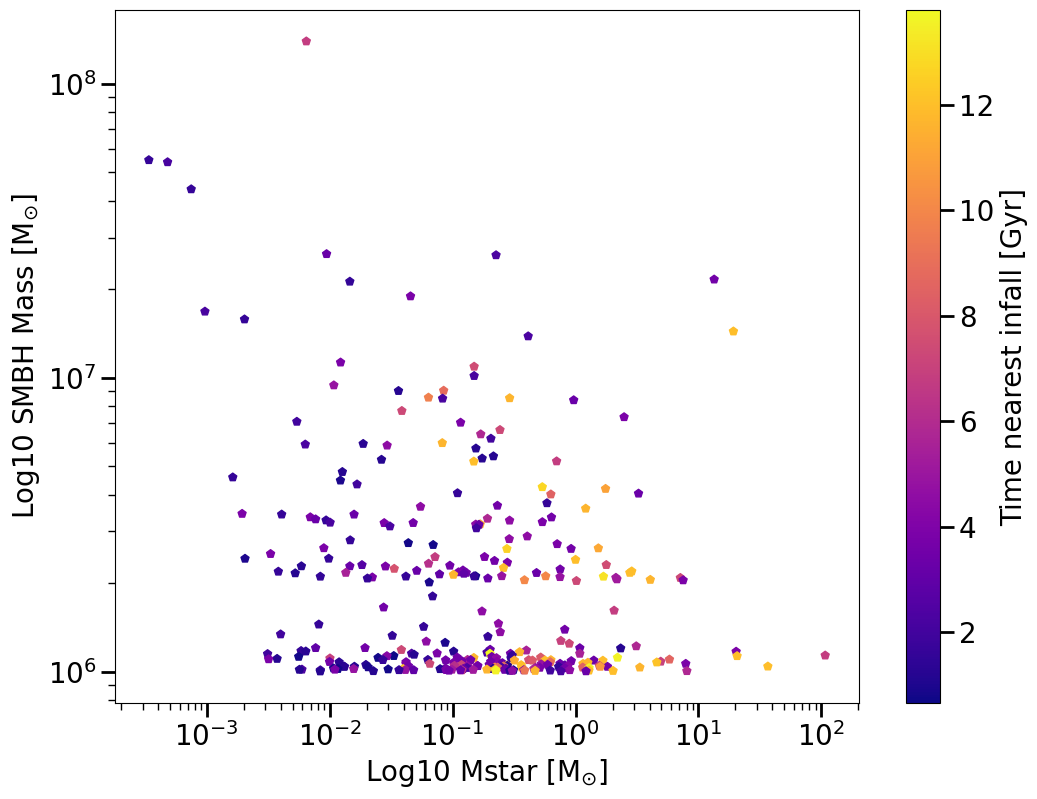

In [6]:
plt.scatter(UCD_mass/UCD_host_mass,UCD_bh_mass,c = (UCD_infall),cmap = 'plasma',marker='p')
plt.yscale('log')
plt.xscale('log')
plt.colorbar(label='Time nearest infall [Gyr]')
plt.ylabel('Log10 SMBH Mass [M$_{\odot}$]')
plt.xlabel('Log10 Mstar [M$_{\odot}$]')
x = UCD_mass/UCD_host_mass
bad = np.where(x > 1)
print(len(x[bad]))

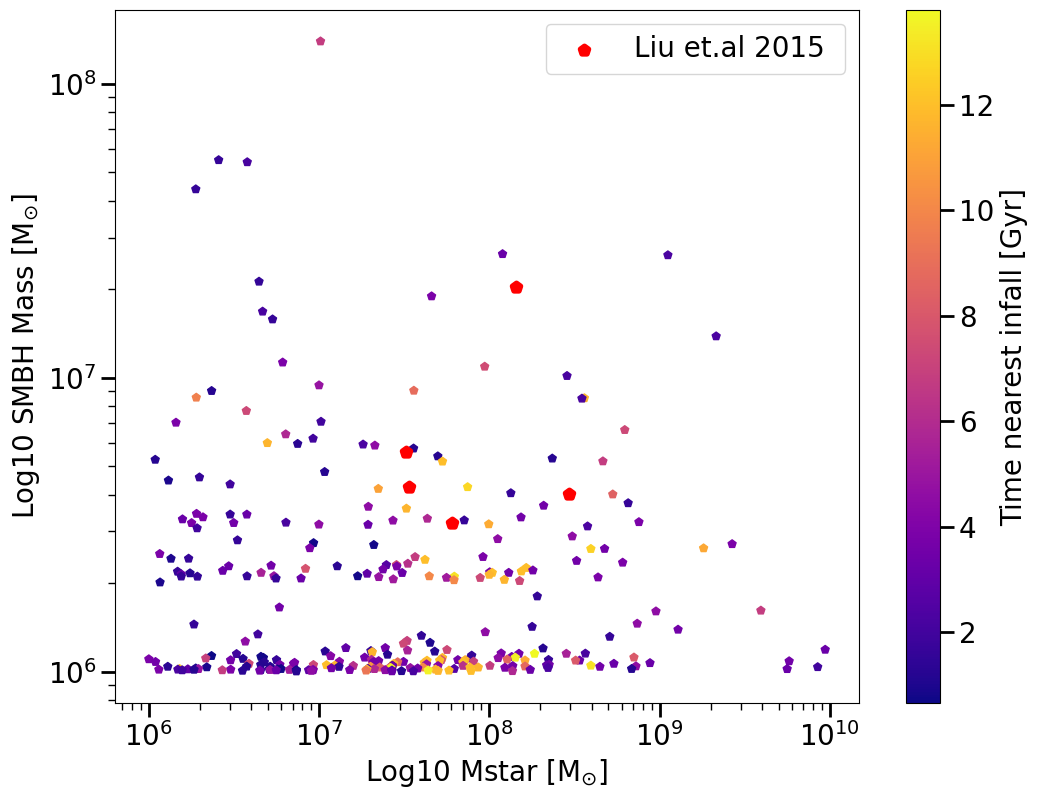

In [28]:
f = open('UCDs_powerlaw.pkl','rb')
data = pck.load(f)
f.close()

UCD_bh_mass = np.array(data['bh_mass'])
UCD_mass=np.array(data['mass'])
UCD_host_mass = np.array(data['host_mass'])
UCD_dist = np.array(data['dist'])
UCD_infall = np.array(data['infall'])
UCD_proxy = np.array(data['proxy'])
UCD_ids = np.array(data['ids'])
UCD_index = np.array(data['index'])
bad = np.where(UCD_mass<10000000000)
#plt.scatter(UCD_mass,UCD_bh_mass,c = (UCD_infall),cmap = 'plasma',marker='o')
#plt.scatter(UCD_proxy,UCD_bh_mass,c = (UCD_infall),cmap = 'binary',marker='p')
plt.scatter(UCD_mass[bad],UCD_bh_mass[bad],c = (UCD_infall[bad]),cmap = 'plasma',marker='p')
plt.yscale('log')
plt.xscale('log')
plt.colorbar(label='Time nearest infall [Gyr]')
plt.ylabel('Log10 SMBH Mass [M$_{\odot}$]')
plt.xlabel('Log10 Mstar [M$_{\odot}$]')
x = [142771855.50051567, 292886385.26811767, 60638233.54077626,32337005.82649589, 33618003.856203355]#, 19982490.252430223]
y = [20344817.370523263, 4038716.314133705, 3200198.552519341, 5572758.119793392, 4258338.690282161]#, 47989.085148563696]
plt.scatter(x,y,c='r',label='Liu et.al 2015 ',marker='p',linewidths=4)
plt.legend(loc='upper right')
plt.savefig('UCDmass_BHmass_infall.png')

In [27]:
mass1=np.where(np.log10(UCD_mass[bad])<=8)
mass2=np.where((np.log10(UCD_mass[bad])>8) & (np.log10(UCD_mass[bad])<=9))
mass3=np.where(np.log10(UCD_mass[bad])>9)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(25,15),sharex='all')

ax1.hist(UCD_dist[mass1],histtype='step',lw=3,density=True,bins=20,color='darkblue',label= 'UCD Mass < 10$^8$ [M$_{\odot}$]')
ax1.hist(UCD_dist[mass2],histtype='step',lw=3,density=True,bins=20,color='mediumvioletred',label='UCD Mass > 10$^8$ & <= 10$^9$ [M$_{\odot}$]')
ax1.hist(UCD_dist[mass3],histtype='step',lw=3,density=True,bins=20,color='orange',label='UCD Mass > 10$^9$ [M$_{\odot}$]')
ax1.legend(loc='upper right')
#ax1.set_title('1.5kpc Density radius')
ax1.set_ylabel('Frequency')
#ax1.set_yscale('log')
#ax1.set_xlabel('g')
mass1=np.where(np.log10(UCD_host_mass[bad])<=8)
mass2=np.where((np.log10(UCD_host_mass[bad])>8) & (np.log10(UCD_mass[bad])<=9))
mass3=np.where(np.log10(UCD_host_mass[bad])>9)
ax2.hist(UCD_dist[mass1],histtype='step',lw=3,density=True,bins=20,color='darkblue',label= 'Host Mass < 10$^8$ [M$_{\odot}$]')
ax2.hist(UCD_dist[mass2],histtype='step',lw=3,density=True,bins=20,color='mediumvioletred',label='Host Mass > 10$^8$ & <= 10$^9$ [M$_{\odot}$]')
ax2.hist(UCD_dist[mass3],histtype='step',lw=3,density=True,bins=20,color='orange',label='Host Mass > 10$^9$ [M$_{\odot}$]')
ax2.legend(loc='upper right')
#ax2.set_title('2kpc Density radius')
#ax2.set_yscale('log')

#ax1.set_xlabel('Gamma Fit Parameter')
#fig.colorbar(cm.ScalarMappable(cmap='rainbow'),label='Log Distance to the Centre of the Cluster [kpc]',location='right')
#fig.colorbar(ax1.scatter(my_saved_data15['Gamma'],my_saved_data15['BH_mass'],c=np.log(my_saved_data15['Cluster_centre_distance']),cmap = 'rainbow'),ax=(ax1,ax2),location='right')
fig.text(0.5,0.05,'Distance from the centre of the cluster at z=0 [kpc]',fontsize=20,ha='center')
plt.savefig('Frequency_masses_dist.png')
plt.show()


NameError: name 'UCD_mass' is not defined

In [6]:
import scipy.stats
mass1=np.where(np.log10(UCD_mass[bad])<9)
mass2=np.where((np.log10(UCD_mass[bad])>8) & (np.log10(UCD_mass[bad])<=9))
mass3=np.where(np.log10(UCD_mass[bad])>9)
mass4 = np.where(np.log10(UCD_mass[bad])>8)
mass5 = np.where(np.log10(UCD_mass[bad])<7)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(25,15),sharex='all')
ax1.hist(UCD_dist[mass1],histtype='step',lw=3,density=True,bins=20,color='darkblue',label= 'UCD Mass < 10$^8$ [M$_{\odot}$]')
ax1.hist(UCD_dist[mass2],histtype='step',lw=3,density=True,bins=20,color='mediumvioletred',label='UCD Mass > 10$^8$ & <= 10$^9$ [M$_{\odot}$]')
ax1.hist(UCD_dist[mass3],histtype='step',lw=3,density=True,bins=20,color='orange',label='UCD Mass > 10$^9$ [M$_{\odot}$]')

#plt.plot(x,y)

ax1.legend(loc='upper right')
#ax1.set_title('1.5kpc Density radius')
ax1.set_ylabel('Frequency')
#ax1.set_yscale('log')
#ax1.set_xlabel('g')
#ax2.set_yscale('log')
x,n = np.histogram(UCD_dist,bins=1000)
x1,n1  = np.histogram(UCD_dist[mass4],bins=1000)
x2,n2 = np.histogram(UCD_dist[mass1],bins=1000)
x3,n3 = np.histogram(UCD_dist[mass5],bins=1000)
x4,n4 = np.histogram(UCD_dist[mass3],bins=1000)
y = np.cumsum(x)
y1= np.cumsum(x1)
y2= np.cumsum(x2)
y3= np.cumsum(x3)
y4 = np.cumsum(x4)
ax2.plot(y,n[1:])
ax2.plot(y1,n1[1:])
ax2.plot(y2,n2[1:])

fig.text(0.5,0.05,'Distance from the centre of the cluster at z=0 [kpc]',fontsize=20,ha='center')
#plt.savefig('Frequency_masses_dist.png')

ax2.legend(loc='lower right')
plt.show()


NameError: name 'UCD_mass' is not defined

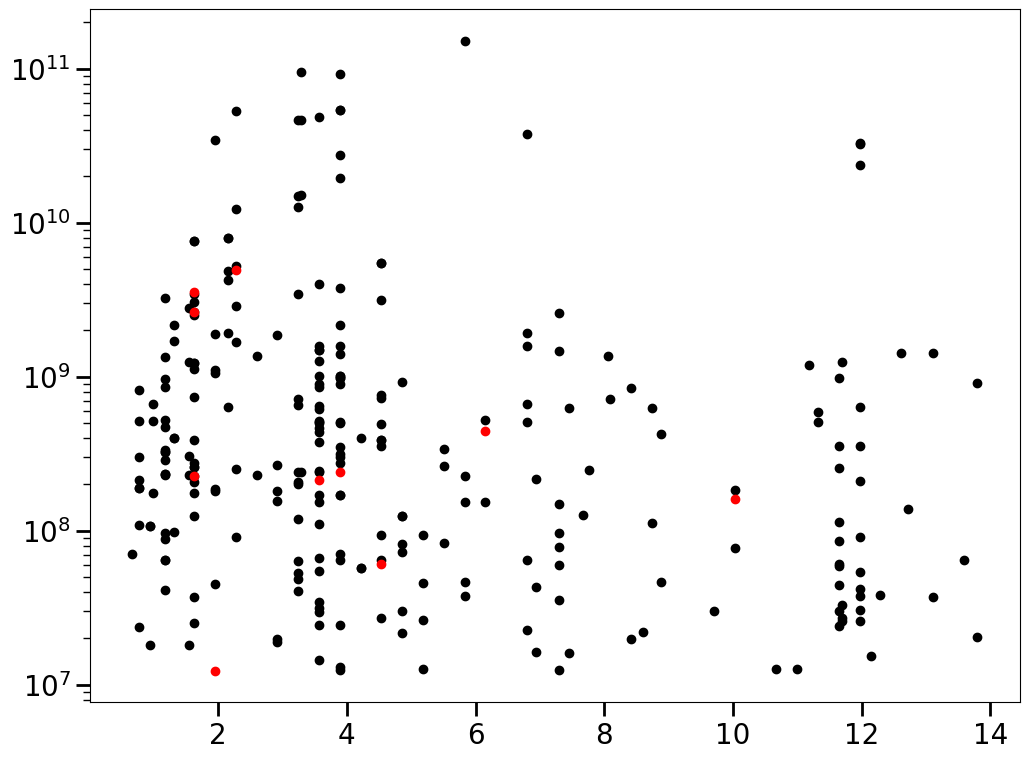

In [73]:

plt.scatter(UCD_infall[mass1],UCD_host_mass[mass1],c='k')
plt.scatter(UCD_infall[mass3],UCD_host_mass[mass3],c='r')
plt.yscale('log')

In [5]:
plt.plot(n[1:],y/len(UCD_dist),label='All UCD Masses')
plt.plot(n4[1:],y4/len(UCD_dist[mass3]),label = 'UCD Mass > 10$^9$',c='darkorange')
plt.plot(n1[1:],y1/len(UCD_dist[mass4]),label = 'UCD Mass > 10$^8$',c='mediumvioletred')
plt.plot(n2[1:],y2/len(UCD_dist[mass1]),label= 'UCD Mass <= 10$^8$',c='deeppink')
plt.plot(n3[1:],y3/len(UCD_dist[mass5]),label = 'UCD Mass < 10$^7$',c = 'darkblue')
plt.legend(loc='lower right')
#plt.ylabel('M$_*$ [M$_{\odot}$]')
plt.xlabel('R$_c$ [kpc]')
plt.ylabel('Cumulative Distribution')
plt.savefig('UCDmass_Norm_dist.png')


NameError: name 'n' is not defined

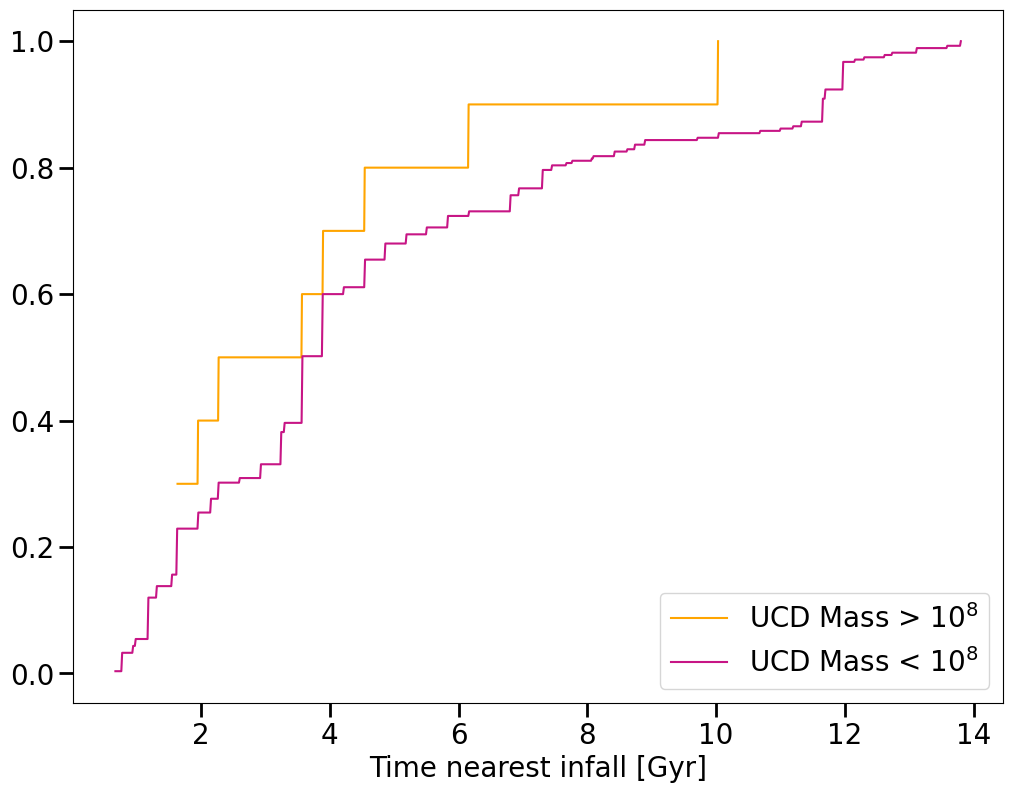

In [71]:
#m1 = np.where(np.log10(UCD_mass[bad] > 9))
#m2 = np.where(np.log10(UCD_mass[bad] < 8))
#plt.scatter(UCD_infall[m1],np.log10(UCD_host_mass[m1]),c='r')
#plt.scatter(UCD_infall[m2],np.log10(UCD_host_mass[m2]),c='k')
x,n = np.histogram(UCD_infall[mass3],bins=1000)
x1,n1  = np.histogram(UCD_infall[mass1],bins=1000)
y = np.cumsum(x)
y1= np.cumsum(x1)
plt.plot(n[1:],y/len(UCD_infall[mass3]),c='orange', label = 'UCD Mass > 10$^8$')
plt.plot(n1[1:],y1/len(UCD_infall[mass1]),c='mediumvioletred',label = 'UCD Mass < 10$^8$')
plt.xlabel('Time nearest infall [Gyr]')
plt.legend(loc='lower right')
plt.savefig('dist_time.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[44350135.25247441, 31642018.16647417, 31642018.16647417, 31642018.16647417, 3421777.885963406, 3421777.885963406, 3421777.885963406, 3288643.0189531306, 3288643.0189531306, 3288643.0189531306, 3288643.0189531306, 3288643.0189531306, 3288643.0189531306, 3288643.0189531306, 3288643.0189531306, 3288643.0189531306, 3288643.0189531306, 3288643.0189531306, 1895065.2749209758, 1895065.2749209758, 1895065.2749209758, 1895065.2749209758, 1895065.2749209758, 1895065.2749209758, 1895065.2749209758, 1895065.2749209758, 1895065.2749209758, 1895065.2749209758, 1895065.2749209758, 1895065.2749209758, 942301.8980083403, 942301.8980083403, 942301.8980083403, 942301.8980083403, 942301.8980083403, 942301.8980083403, 942301.8980083403, 942301.8980083403, 942301.8980083403, 942301.8980083403, 942301.8980083403, 942301.8980083403, 942301.8980083403, 942301.8980083403, 942301.8980083403, 942301.8980083403, 942301.8980083403, 942301.8980083403, 942301.8980083403, 942301.8980083403, 942301.8980083403, 942301.

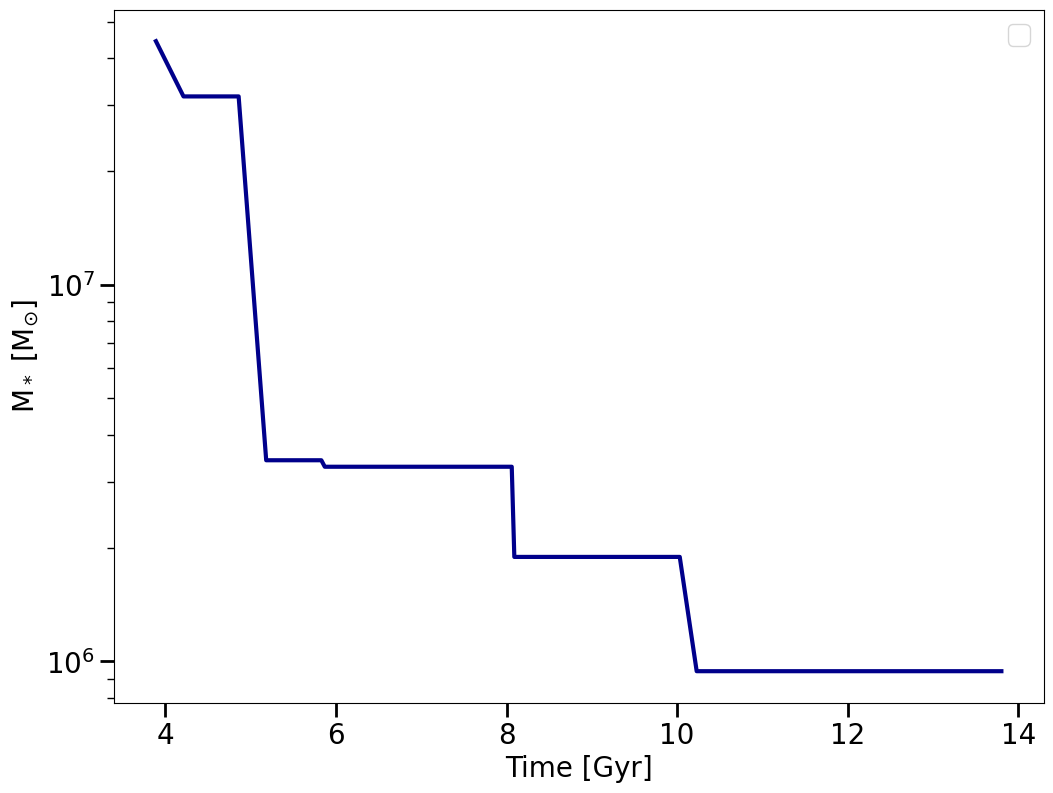

In [21]:
f = open('Extrapolation_Outputs.pkl','rb')
data = pck.load(f)
f.close()
ids=data['bhid']
index=data['index']
a=data['a']
b=data['b']
step=data['step']
host=data['host']
x=8
r_j,time,mass,bh_mass,infall = tidal_history(a[x],b[x],ids[x],index[x],step[x],host[x])
print(mass)
plt.plot(time,mass,c='darkblue',lw='3')
plt.ylabel('M$_*$ [M$_{\odot}$]')
plt.xlabel('Time [Gyr]')
plt.legend(loc='upper right')
plt.yscale('log')
#plt.title('Mass evolution from Infall to 13.8 Gyrs')
#plt.xscale('log')
plt.savefig('Mass Evolution.png')


In [40]:
f = open('Disruption_Outputs.pkl','rb')
data = pck.load(f)
f.close()

time = data['time']
mass = data['mass']
bh_mass=data['bh_mass']
infall = np.array(data['infall'])

f = open('Extrapolation_Outputs.pkl','rb')
old_data = pck.load(f)
f.close()

ids = np.array(old_data['bhid'])
dist = np.array(old_data['dist'])
host_mass = np.array(old_data['hostmass'])
index=np.array(old_data['index'])
a=np.array(old_data['a'])
b=np.array(old_data['b'])
step=np.array(old_data['step'])
host=np.array(old_data['host'])

f = open('UCD_proxy.pkl','rb')
vold_data = pck.load(f)
f.close()

UCD_proxy = np.array(vold_data['mass'])

UCD_index = []
UCD_bh_mass = []
UCD_mass=[]
other_index=[]

for i in range(len(time)):
    if mass[i][-1]>1000000:
        other_index.append(index[i]) 
        UCD_index.append(i)
print(len(mass))
print(len(UCD_index))
for i in range(len(other_index)):
    UCD_mass.append(mass[UCD_index[i]][-1])
    UCD_bh_mass.append(bh_mass[UCD_index[i]][-1])
    
UCD_host_mass = host_mass[UCD_index]
UCD_dist = dist[UCD_index]
infall = infall[UCD_index]
UCD_proxy = UCD_proxy[UCD_index]
UCD_ids = ids[UCD_index]
UCD_a = a[UCD_index]
UCD_b = b[UCD_index]
UCD_step = step[UCD_index]
UCD_host = host[UCD_index]


data_to_file={'a':UCD_a,'b':UCD_b,'step':UCD_step,'host':UCD_host,'ids':UCD_ids,'index':other_index,'bh_mass':UCD_bh_mass,'mass':UCD_mass,'host_mass':UCD_host_mass,'dist':UCD_dist,'infall':infall,'proxy':UCD_proxy}
f = open('UCDs_powerlaw.pkl','wb')
pck.dump(data_to_file,f)
f.close()

424
299


In [29]:
f = open('Extrapolation_Outputs.pkl','rb')
data = pck.load(f)
f.close()
ids=data['bhid']
index=data['index']
a=data['a']
b=data['b']
step=data['step']
host=data['host']

rj=[]
t=[]
m=[]
infal=[]
bh_m=[]

for i in range(len(index)):
    r_j,time,mass,bh_mass,infall = tidal_history(a[i],b[i],ids[i],index[i],step[i],host[i])
    rj.append(r_j)
    t.append(time)
    m.append(mass)
    infal.append(infall)
    bh_m.append(bh_mass)
    print(index[i])

data_to_file={'rj':rj,'time':t,'mass':m,'bh_mass':bh_m,'infall':infal}
f = open('Disruption_Outputs.pkl','wb')
pck.dump(data_to_file,f)
f.close()

0
1
2
3
4
5
6
7
9
10
12
13
14
15
16
17
21
22
24
25
26
27
29
30
34
35
37
39
42


/home/msupernak/miniconda3/lib/python3.10/site-packages/tangos/live_calculation/__init__.py:616: RuntimeWarning: More than one relation for target 'host_halo' has been found. Picking the first.
  warnings.warn("More than one relation for target %r has been found. Picking the first."%str(self.locator), RuntimeWarning)


45
46
51
53
54
55
56
57
58
61
63
64
65
66
69
70
72
73
74
77
79
80
82
84
85
86
89
90
93
94
98
99
100
101
105
110
111
112
113
116
117
120
121
126
132
135
137
139
141
146
149
156
157
159
163
167
169
171
172
174
180
181
183
184
185
188
194
195
196
198
199
200
202
203
206
208


/home/msupernak/miniconda3/lib/python3.10/site-packages/tangos/relation_finding/multi_hop.py:387: SAWarning: This declarative base already contains a class with the same class name and module name as tangos.relation_finding.multi_hop.MultiHopHaloLink_xelf, and will be replaced in the string-lookup table.
  return type(class_name,class_base,class_attrs)


209
211
212
213
217
218
220
222
223
225
232
241
244
245
246
248
249
250
251
252
254
255
256
257
261
267
268
274
275
277
280
282
283
284
285
287
289
291
292
294
298
303
305
308
311
314
316
318
323
327
328
329
330
334
335
342
344
346
350
361
368
370
371
372
373
374
376
377
379
380
386
389
390
392
394
396
401
406
411
415
416
420
436
438
443
452
453
463
495
502
514
515
516
517
518
521
522
523
524
525
528
532
535
537
540
542
547
548
553
555
562
566
567
579
586
587
589
592
593
599
600
606
610
614
615
617
618
619
622
625
630
636
638
640
641
642
644
645
650
651
662
663
665
669
670
671
672
677
683
685
686
692
693
696
698
700
702
704
705
709
714
718
725
729
730
732
736
737
741
742
744
748
750
751
752
753
768
771
777
781
785
789
795
799
801
805
806
809
815
818
822
823
825
839
840
860
862
864
866
868
881
887
890
897
906
910
912
913
916
918
929
937
957
958
959
962
963
965
973
982
984
987
1001
1016
1019
1027
1038
1041
1045
1046
1048
1051
1052
1056
1063
1064
1075
1084
1095
1108
1123
1124
1127
1129
11

In [119]:
a=[]
b=[]
bhid=[]
step=[]
host=[]
bh_mass=[]
intime=[]
host_mass=[]
dist=[]
index=[]

for i in range(1970):
        
    A,B,BHid,stepp,original,bhm,time,hostm,dis,ind = host_density(1,i)
      
    if A == 0 :
        pass
    
    else: 
            
        a.append(A)
        b.append(B)
        bhid.append(BHid)
        stepp = stepp.path
        step.append(stepp)
        original = original.path
        host.append(original)
        bh_mass.append(bhm)
        intime.append(time)
        host_mass.append(hostm)
        dist.append(dis)
        index.append(ind)
    
    print('N:',i)
    
data_to_file = {'a':a,'b':b,'bhid':bhid,'step':step,'host':host,'bhmass':bh_mass,'intime':intime,'hostmass':host_mass,'dist':dist,'index':index}
f = open('Extrapolation_Outputs.pkl','wb')
pck.dump(data_to_file,f)
f.close()


Original BH Host: 3
BH id: 568940603
Time in simulation: 0.9812292056226746 Gyr
N: 0


/tmp/ipykernel_428496/2626741609.py:176: RuntimeWarning: divide by zero encountered in power
  y = a*x**(-b)


Original BH Host: 68
BH id: 568941788
Time in simulation: 1.5467983949884065 Gyr
N: 1
Original BH Host: 22
BH id: 568983956
Time in simulation: 0.7657742763411864 Gyr
N: 2
Original BH Host: 10
BH id: 568954394
Time in simulation: 1.627593993470575 Gyr
N: 3
Original BH Host: 51
BH id: 568947277
Time in simulation: 2.152765383604354 Gyr
N: 4
Original BH Host: 13
BH id: 569083338
Time in simulation: 1.3044115995449361 Gyr
N: 5
Original BH Host: 21
BH id: 568954823
Time in simulation: 1.627593993470575 Gyr
N: 6
Original BH Host: 7
BH id: 569034332
Time in simulation: 0.9340984398422605 Gyr
N: 7
ERROR: no original host
N: 8
Original BH Host: 86
BH id: 568945875
Time in simulation: 0.9812292056226746 Gyr
N: 9


/home/msupernak/miniconda3/lib/python3.10/site-packages/tangos/live_calculation/__init__.py:616: RuntimeWarning: More than one relation for target 'host_halo' has been found. Picking the first.
  warnings.warn("More than one relation for target %r has been found. Picking the first."%str(self.locator), RuntimeWarning)


Original BH Host: 183
BH id: 568946292
Time in simulation: 0.9340984398422605 Gyr
N: 10
ERROR: host galaxy not resolved
N: 11
Original BH Host: 2896
BH id: 568954059
Time in simulation: 1.9507763873998631 Gyr
N: 12
Original BH Host: 42
BH id: 568944270
Time in simulation: 2.920323569180768 Gyr
N: 13
Original BH Host: 66
BH id: 568965228
Time in simulation: 1.9507763873998631 Gyr
N: 14
Original BH Host: 44
BH id: 569017643
Time in simulation: 2.273958781327042 Gyr
N: 15
Original BH Host: 26
BH id: 569013861
Time in simulation: 1.627593993470575 Gyr
N: 16
Original BH Host: 14
BH id: 568952546
Time in simulation: 0.7657742763411864 Gyr
N: 17
ERROR the BH never met the three conditions
N: 18
ERROR: host galaxy not resolved
N: 19
ERROR: no original host
N: 20
Original BH Host: 12
BH id: 569013229
Time in simulation: 0.9812292056226746 Gyr
N: 21
Original BH Host: 30
BH id: 569025670
Time in simulation: 1.9507763873998631 Gyr
N: 22
ERROR: This BH was never central
N: 23
Original BH Host: 44
B

/home/msupernak/miniconda3/lib/python3.10/site-packages/tangos/relation_finding/multi_hop.py:387: SAWarning: This declarative base already contains a class with the same class name and module name as tangos.relation_finding.multi_hop.MultiHopHaloLink_ejol, and will be replaced in the string-lookup table.
  return type(class_name,class_base,class_attrs)


ERROR: This BH was never central
N: 505
ERROR: This BH was never central
N: 506
ERROR: This BH was never central
N: 507
ERROR: This BH was never central
N: 508
ERROR: This BH was never central
N: 509
ERROR: This BH was never central
N: 510
ERROR: host galaxy not resolved
N: 511
ERROR the BH never met the three conditions
N: 512
ERROR: This BH was never central
N: 513
Original BH Host: 27
BH id: 569637580
Time in simulation: 1.5467983949884065 Gyr
N: 514
Original BH Host: 278
BH id: 570181584
Time in simulation: 0.9812292056226746 Gyr
N: 515
Original BH Host: 2141
BH id: 569471202
Time in simulation: 2.273958781327042 Gyr
N: 516
Original BH Host: 214
BH id: 569236695
Time in simulation: 2.920323569180768 Gyr
N: 517
Original BH Host: 60
BH id: 569309915
Time in simulation: 3.243505963111683 Gyr
N: 518
ERROR: This BH was never central
N: 519
ERROR: This BH was never central
N: 520
Original BH Host: 816
BH id: 569449541
Time in simulation: 0.9812292056226746 Gyr
N: 521
Original BH Host: 24

/home/msupernak/miniconda3/lib/python3.10/site-packages/tangos/relation_finding/multi_hop.py:387: SAWarning: This declarative base already contains a class with the same class name and module name as tangos.relation_finding.multi_hop.MultiHopHaloLink_vmhd, and will be replaced in the string-lookup table.
  return type(class_name,class_base,class_attrs)


ERROR: The original host has no density profile
N: 933
ERROR: host galaxy not resolved
N: 934
ERROR: The original host has no density profile
N: 935
ERROR: This BH was never central
N: 936
Original BH Host: 259
BH id: 569399998
Time in simulation: 1.3044115995449361 Gyr
N: 937
Original BH Host: 2324
BH id: 569076762
Time in simulation: 2.5971411752518447 Gyr
ERROR: Star density within 0.7kpc is zero
N: 938
ERROR: This BH was never central
N: 939
ERROR: This BH was never central
N: 940
ERROR: This BH was never central
N: 941
ERROR: This BH was never central
N: 942
ERROR: This BH was never central
N: 943
ERROR: This BH was never central
N: 944
ERROR: This BH was never central
N: 945
ERROR: This BH was never central
N: 946
ERROR: no original host
N: 947
ERROR: This BH was never central
N: 948
ERROR: This BH was never central
N: 949
ERROR: host galaxy not resolved
N: 950
ERROR: This BH was never central
N: 951
ERROR: This BH was never central
N: 952
ERROR: This BH was never central
N: 953


/home/msupernak/miniconda3/lib/python3.10/site-packages/tangos/relation_finding/multi_hop.py:387: SAWarning: This declarative base already contains a class with the same class name and module name as tangos.relation_finding.multi_hop.MultiHopHaloLink_docu, and will be replaced in the string-lookup table.
  return type(class_name,class_base,class_attrs)


ERROR: This BH was never central
N: 1766
ERROR: This BH was never central
N: 1767
ERROR the BH never met the three conditions
N: 1768
ERROR: This BH was never central
N: 1769
ERROR: This BH was never central
N: 1770
ERROR: This BH was never central
N: 1771
ERROR: This BH was never central
N: 1772
ERROR: This BH was never central
N: 1773
ERROR: This BH was never central
N: 1774
ERROR: This BH was never central
N: 1775
ERROR: This BH was never central
N: 1776
ERROR: This BH was never central
N: 1777
Original BH Host: 366
BH id: 570476065
Time in simulation: 1.3044115995449361 Gyr
N: 1778
ERROR: This BH was never central
N: 1779
ERROR: This BH was never central
N: 1780
ERROR: This BH was never central
N: 1781
ERROR: This BH was never central
N: 1782
ERROR: This BH was never central
N: 1783
ERROR: This BH was never central
N: 1784
ERROR: This BH was never central
N: 1785
ERROR: This BH was never central
N: 1786
ERROR: This BH was never central
N: 1787
ERROR: This BH was never central
N: 17